In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy
import os

import nltk
from nltk.grammar import DependencyGrammar
from nltk.parse import DependencyGraph,ProjectiveDependencyParser,NonprojectiveDependencyParser

from nltk import word_tokenize
from collections import Counter

from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

from nltk.corpus import stopwords
stopword_list = stopwords.words('english')

import string
for punct_mark in string.punctuation:
    stopword_list.append(punct_mark)

In [2]:
df = pd.read_csv('banned_book_data_combined_lists.csv')
df_reason = df[ df['reason'].notna() ]
total_nr_reasons = df_reason.shape[0]
print(f"The dataset contains {total_nr_reasons} motivations.")

The dataset contains 30229 motivations.


## Motivations

In [3]:
lexicon = pd.read_csv('lexicon.csv')
lexicon_terms = dict()

for i,row in lexicon.iterrows():
    if re.search(r'\w',row['word']) and not(re.search(r'\b\d+\b',row['word'])) and not(re.search(r'\b\d+\b',row['category'])):
        lexicon_terms[row['word']]=row['category'].strip()     

In [4]:
categories = dict()

for i,row in df_reason.iterrows():
    category_list = []
    reason = str(row['reason']).lower()
    words = word_tokenize(str(reason))
    words = [word for word in words if word not in stopword_list]
    words = [word for word in words if not(re.search(r'\d+^$',word))]
    words = [lemmatiser.lemmatize(word) for word in words]
    for word in words:
        if word in lexicon_terms:
            category = lexicon_terms[word].strip()
            category_list.append(category)
    categories[f"{i}#{reason}"]=set(category_list)

In [5]:
count=0
for reason in categories:
    if len(categories[reason])>0:
        count+=1
print(f'{count} motivations have been categorised.')
print(f'{total_nr_reasons-count} motivations have NOT been assigned a category.')

17683 motivations have been categorised.
12546 motivations have NOT been assigned a category.


## The categorised motivations are saved in a TXT file

In [6]:
directory = 'Categories'
if not os.path.exists(directory):
    os.makedirs(directory)

for category in set(lexicon_terms.values()):
    file_name = os.path.join(directory,f'{category}.txt')
    file_name = re.sub(r'\s+' , '_' , file_name)
    out = open(file_name,'w',encoding='utf-8')
    out.close()

file_name = os.path.join(directory,f'unknown.txt')
out = open(file_name,'w',encoding='utf-8')
out.close()

In [7]:
for i,row in df_reason.iterrows():
    key = f"{i}#{row['reason'].lower()}"
    if key in categories:
        category_list = categories[key]
        if len(category_list)==0:
            with open(os.path.join(directory,f'unknown.txt'), "a") as fh:
                fh.write(f"{row['reason']}\n")
        else:           
            for category in category_list:
                file_name = os.path.join(directory,f'{category}.txt')
                file_name = re.sub(r'\s+' , '_' , file_name)
                with open(file_name, "a") as fh:
                    fh.write(f"{row['reason']}\n")

        

In [8]:
category_count = dict()

files = os.listdir(directory)
files = [os.path.join(directory,file) for file in files if not(re.search('^[.]',file))]
for file in files:
    category = os.path.basename( os.path.splitext(file)[0] )
    fh = open(file)
    nr_lines = len(fh.readlines())

    if category != 'unknown':
        category_count[category] = nr_lines
    

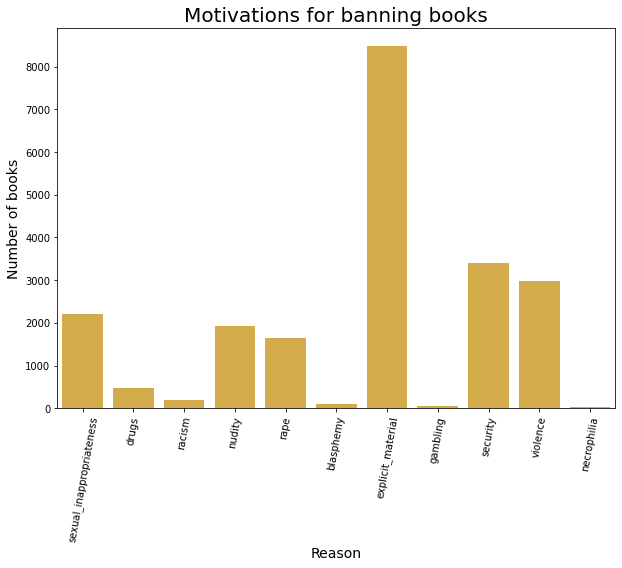

In [9]:
x_axis = list(category_count.keys())
y_axis = list(category_count.values())

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure( figsize=( 10 , 7 ) )

graph = sns.barplot( x=x_axis, y=y_axis , color = '#ebb434')

graph.set_title('Motivations for banning books' , size = 20) 
graph.set_xlabel('Reason' , size = 14) 
graph.set_ylabel('Number of books' , size = 14 )

plt.xticks(rotation= 80)
# The next line places the legend outside out the plot


plt.show()